In [1]:
import numpy as np
import scipy as sp
import sympy as smp
from scipy.integrate import solve_ivp
import mpmath

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import snoop

In [2]:
def ode(t,y,p):
    """nondimentionalised eq. of motion written as coupled ODEs to be solved"""

    theta = y[0]
    omega = y[1]
    c,rho=p

    return np.array([omega, -c * omega - np.sin(theta) + rho * np.sin(t)])

In [3]:
np.abs(((np.pi+np.pi+1e-10) % (2 * np.pi) ))<1e-10

False

In [4]:
# p=[0.1,2.5]
p=[0.0,0.0]

In [5]:
y0=[1.0,1.0]

In [6]:
sol = solve_ivp(
    fun=ode,
    t_span=[0.0, 50000.0],
    y0=y0,
    method="LSODA",
    t_eval=np.arange(0.0, 50000.0 , 2*np.pi),
    args=(p,),
    rtol=1e-9,
    atol=1e-9)

In [7]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.283e+00 ...  4.999e+04  5.000e+04]
        y: [[ 1.000e+00 -3.644e-01 ... -1.324e+00 -1.442e+00]
            [ 1.000e+00  1.337e+00 ...  6.393e-01 -4.207e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1483149
     njev: 0
      nlu: 0

In [8]:
sol.y

array([[ 1.        , -0.36441691, -1.40328598, ..., -0.17513906,
        -1.32362425, -1.44160845],
       [ 1.        ,  1.33718317,  0.50284341, ...,  1.37432139,
         0.63928131, -0.42072832]])

In [9]:
rsol=sol.y

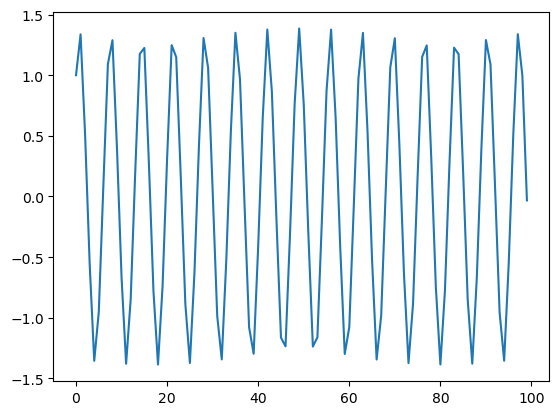

In [158]:
plt.plot(rsol[1][:100])

In [10]:
time= sol.t

In [11]:
time.shape

(7958,)

In [12]:
th_wrapped = np.arctan2(np.sin(rsol[0]), np.cos(rsol[0]))

In [13]:
th_wrapped

array([ 1.        , -0.36441691, -1.40328598, ..., -0.17513906,
       -1.32362425, -1.44160845])

In [14]:
rsol[0]

array([ 1.        , -0.36441691, -1.40328598, ..., -0.17513906,
       -1.32362425, -1.44160845])

(0.0, 70.0)

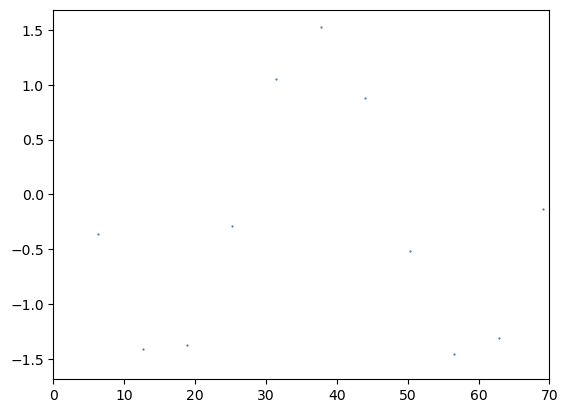

In [15]:
plt.scatter(time,th_wrapped,s=0.3)
plt.xlim(0.,70.)

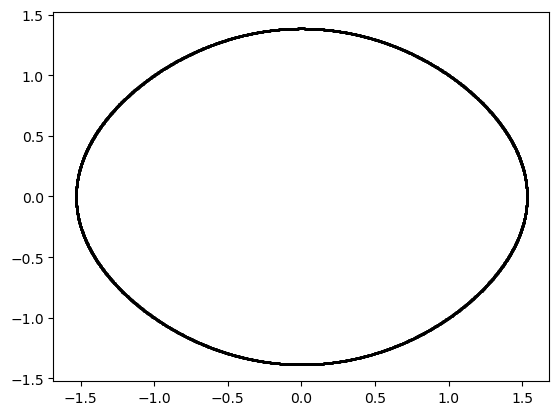

In [16]:
plt.scatter(th_wrapped, rsol[1], s=0.5,c='black')

### Deviation Vector Approach without Rescaling

In [161]:
y0 = np.array([1.0, 1.0])

In [162]:
eps=1e-6
y1=y0+np.random.uniform(0.,1.,len(y0))*eps

In [163]:
y1

array([1.0000003 , 1.00000015])

In [164]:
soly0 = solve_ivp(
    fun=ode,
    t_span=[0.0, 50000.0],
    y0=y0,
    method="LSODA",
    t_eval=np.arange(0.0, 50000.0, 1e-2),
    args=(p,),
    rtol=1e-10,
    atol=1e-10,
)

In [165]:
soly1 = solve_ivp(
    fun=ode,
    t_span=[0.0, 50000.0],
    y0=y1,
    method="LSODA",
    t_eval=np.arange(0.0, 50000.0, 1e-2),
    args=(p,),
    rtol=1e-10,
    atol=1e-10,
)

In [166]:
inorm= np.linalg.norm(y1-y0)

In [167]:
inorm

3.360688558774898e-07

In [168]:
rsoly0= soly0.y.T
rsoly1= soly1.y.T

In [169]:
np.linalg.norm(rsoly1 - rsoly0, axis=1).max()

0.006135435027315649

In [170]:
ret=np.linalg.norm(rsoly1-rsoly0,axis=1)/inorm

In [171]:
np.arange(0.0, 50000.0, 1e-2)[:20001]

array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.9998e+02, 1.9999e+02,
       2.0000e+02])

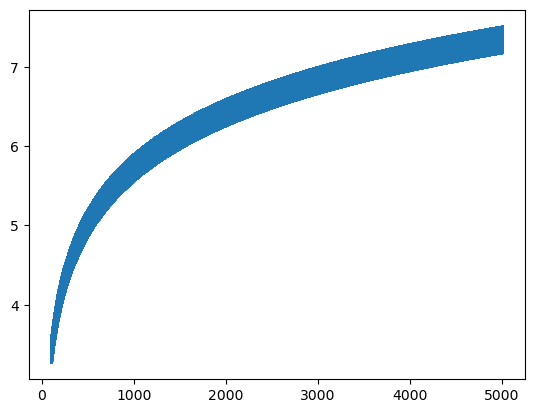

In [175]:
plt.scatter(np.arange(0.0, 50000.0, 1e-2)[10000:500000],np.log(ret)[10000:500000],s=0.5)

In [173]:
intcept1, lyap1 = (
    np.polynomial.polynomial.Polynomial.fit(
        np.arange(0.0, 50000.0, 1e-2)[:15000], np.log(ret)[:15000], 1
    )
    .convert()
    .coef
)

In [174]:
lyap1

0.018856038920925133

### Deviation Vector Approach with Rescaling

In [176]:
y0=[1.0,1.0]

In [177]:
eps = 1e-7
np.random.seed(1)
y1 = y0 + np.random.uniform(0.0, 1.0, len(y0)) * eps

In [178]:
tf=10000
tau=100

In [179]:
# wy1 = np.arctan2(np.sin(y1[0]), np.cos(y1[0]))
# wy0 = np.arctan2(np.sin(y0[0]), np.cos(y0[0]))

In [180]:
inorm = np.linalg.norm(y1 - y0)

In [181]:
inorm

8.323309000964008e-08

In [439]:
# @snoop
def evolve_lyap2(y0, y1, p):
    ti = 0.0
    timestep = np.arange(ti, tf + tau, tau)

    re = np.zeros((len(timestep)))

    for i in range(len(timestep)-1):
        # t_span = [timestep[i], timestep[i + 1]]
        t_span=[0.,tau]
        soly0 = solve_ivp(
            fun=ode,
            t_span=t_span,
            y0=y0,
            method="LSODA",
            t_eval=[tau],
            args=(p,),
            rtol=1e-10,
            atol=1e-10,
            max_step=tau
        ).y[:, -1]

        soly1 = solve_ivp(
            fun=ode,
            t_span=t_span,
            y0=y1,
            method="LSODA",
            t_eval=[tau],
            args=(p,),
            rtol=1e-10,
            atol=1e-10,
            max_step=tau
        ).y[:, -1]


        delyr = (soly1 - soly0) / np.linalg.norm((soly0 - soly1))

        delyr = delyr * inorm

        re[i+1] = np.log(np.linalg.norm((soly1 - soly0)) / inorm)


        y1 = soly0 + delyr
        y0 = soly0
    return re

In [440]:
retau=evolve_lyap2(y0,y1,p)

In [441]:
timestep = np.arange(0.0, tf + tau, tau)

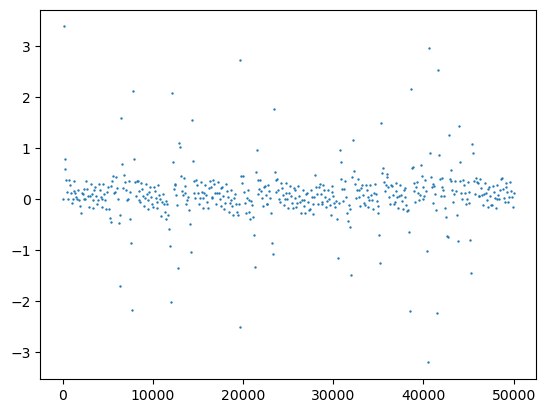

In [442]:
plt.scatter(timestep, retau, s=0.5)

In [443]:
retau[0]

0.0

In [444]:
(np.abs(retau)<1e-8).sum()

1

In [445]:
np.average(retau[100:])

0.0818624708364058

In [446]:
retau[-10:]

array([ 0.32077057,  0.24508498,  0.1470193 , -0.06298048,  0.04095695,
        0.3473042 ,  0.15624563,  0.03871627, -0.15680605,  0.13226361])

In [447]:
timestep.shape,retau.shape

((501,), (501,))

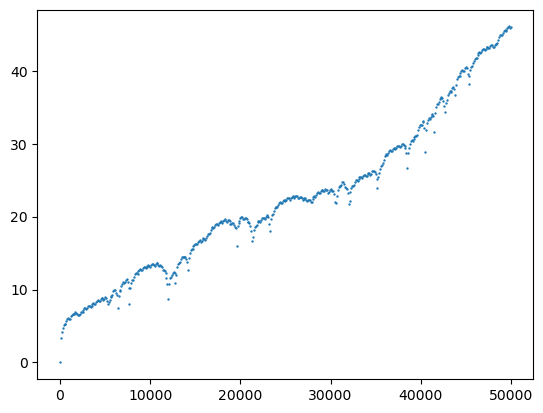

In [448]:
plt.scatter(timestep,np.cumsum(retau),s=0.5)

In [449]:
intcept, lyap2 = (
    np.polynomial.polynomial.Polynomial.fit(timestep[20:], np.cumsum(retau)[20:], 1)
    .convert()
    .coef
)

In [450]:
lyap2

0.0007345805990708214

### Jacobian Method

In [48]:
def jac(t, y, p):
    c, rho = p
    theta, omega = y

    return np.array(
        [[0.0, 1.0, 0.0], [-np.cos(theta), -c, rho * np.cos(t)], [0.0, 0.0, 0]]
    )

In [49]:
def solve_combined(t,y,p):
    c,rho=p
    theta,omega= y[0],y[1]
    der= np.zeros(6)

    der[0] = omega
    der[1]= -c * omega - np.sin(theta) + rho * np.sin(t)
    der[2] =1.0

    J = np.array(
        [[0.0, 1.0, 0.0], [-np.cos(theta), -c, rho * np.cos(t)], [0.0, 0.0, 0]]
    )

    dY= J.dot(y[3:].reshape((3,1)))
    der[3:]= dY.flatten()

    return der



In [50]:
w0_=np.random.uniform(0.,1.,3)
w0=w0_/np.linalg.norm(w0_)

In [51]:
w0

array([3.40331479e-04, 8.99614914e-01, 4.36683970e-01])

In [52]:
ics= np.array([[1.0,1.0,0.0],w0]).flatten()

In [53]:
ics

array([1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 3.40331479e-04,
       8.99614914e-01, 4.36683970e-01])

In [54]:
solve_combined(0.,ics,p)

array([ 1.00000000e+00, -8.41470985e-01,  1.00000000e+00,  8.99614914e-01,
       -1.83881883e-04,  0.00000000e+00])

In [55]:
def evolve_lyap(ics0, tau, tf, p):

    ti = 0.0  # * Initial Time
    timestep = np.arange(ti, tf, tau)  # * Time interval
    size = timestep.shape[0]

    X1t = np.zeros((size - 1))  # *Lyapunaov Exponents
    sum = 0.0
    ics = ics0.copy()  # *We do not want to change our initial conditions

    for i in range(0, size - 1):

        # usol = solve_ivp(
        #     solve_combined,
        #     [timestep[i], timestep[i + 1]],
        #     ics,
        #     t_eval=[timestep[i], timestep[i + 1]],
        #     args=(p,),
        #     atol=1e-10,
        #     rtol=1e-10,
        # ).y[:, -1]

        usol = solve_ivp(
            solve_combined,
            [0.,tau],
            ics,
            t_eval=[tau],
            args=(p,),
            atol=1e-10,
            rtol=1e-10,
            max_step=tau
        ).y[:,-1]  

        xk = usol[:3]  # Orbit at t= tau
        wk = usol[3:]  # Deviations at t=tau

        # *---------------------The following algorithm is from the paper

        alphak = np.linalg.norm(wk)
        sum = sum + np.log(alphak)
        X1t[i] = sum / timestep[i + 1]
        wk0 = wk / alphak

        # *----------------------Lyapunaov Exponents calculated above
        #! Now for another time step. Set the current solution as the initial conditions for next time steps
        ics[:3] = xk
        ics[3:] = wk0

    return X1t

In [56]:
tf=20000
tau=100
slyap=evolve_lyap(ics,tau,tf,p)

In [57]:
slyap

array([0.03042991, 0.01906593, 0.01470604, 0.01176953, 0.00961014,
       0.00797583, 0.00733028, 0.00674668, 0.00611581, 0.00541602,
       0.00491948, 0.00478006, 0.00452507, 0.0042237 , 0.00383078,
       0.00365526, 0.00360444, 0.00344831, 0.00324221, 0.00299488,
       0.00295256, 0.0029109 , 0.00280252, 0.00263183, 0.00248725,
       0.00249533, 0.00244895, 0.00236372, 0.00221598, 0.00215084,
       0.0021665 , 0.00211932, 0.00204026, 0.00192028, 0.00190983,
       0.00191445, 0.00187135, 0.00178984, 0.00170638, 0.00172407,
       0.00171442, 0.00167472, 0.00159162, 0.00154874, 0.00157212,
       0.00155315, 0.00151169, 0.00143488, 0.00142747, 0.00144289,
       0.00142087, 0.00137303, 0.00131307, 0.00132823, 0.00133122,
       0.00130875, 0.00125458, 0.00121954, 0.00124214, 0.00123501,
       0.0012101 , 0.00115503, 0.00114612, 0.00116453, 0.00115226,
       0.00112142, 0.00107415, 0.00108496, 0.00109368, 0.00107963,
       0.00104178, 0.00101062, 0.00103044, 0.00102968, 0.00101

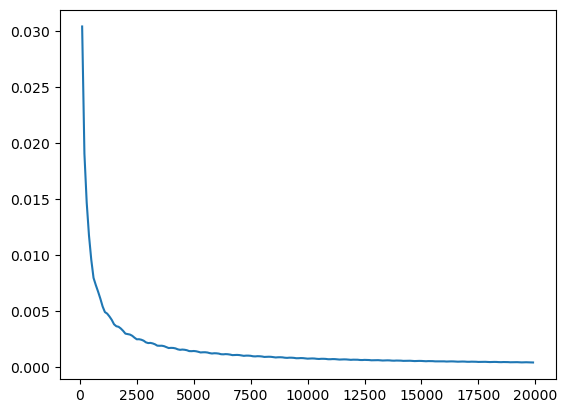

In [58]:
plt.plot(np.arange(0.0, tf, tau)[1:],slyap)

In [59]:
np.average(slyap[100:])

0.000564030187984803

In [60]:
solics = solve_ivp(
    fun=solve_combined,
    t_span=[0.0,2000.0],
    y0=ics,
    method="LSODA",
    t_eval=np.arange(0.0,2000.0, 0.01),
    args=(p,),
    rtol=1e-10,
    atol=1e-10,
)

In [61]:
jaclyap=np.log(np.linalg.norm(solics.y.T[-1][3:]))/2000

In [62]:
jaclyap

0.0029953390401498865

### Multiple Lyapunov Exponent

In [63]:
def msolve_combined(t, y, p):
    c, rho = p
    theta, omega = y[0], y[1]
    der = np.zeros(12)

    der[0] = omega
    der[1] = -c * omega - np.sin(theta) + rho * np.sin(t)
    der[2] = 1.0

    J = np.array(
        [[0.0, 1.0, 0.0], [-np.cos(theta), -c, rho * np.cos(t)], [0.0, 0.0, 0.0]]
    )

    dY = J @ (y[3:].reshape((3, 3)))
    der[3:] = dY.flatten()

    return der

In [64]:
ran_=np.random.uniform(0.,1.,(3,3))
Q_,R_= np.linalg.qr(ran_)
mics= [1.,1.,0.] + Q_.flatten().tolist()

In [65]:
mics

[1.0,
 1.0,
 0.0,
 -0.11583331262336549,
 -0.3415526858609747,
 -0.9326973820419203,
 -0.49772135905271864,
 -0.7926602166685484,
 0.35208412297870617,
 -0.8595673867879191,
 0.5050064788615334,
 -0.07818160831335785]

In [66]:
mtau=50
mtf=20000

In [67]:
tspan= [0.,mtf]
t_eval= np.linspace(*tspan,10000)

In [68]:
# p=[0.1,2.5]


In [69]:
# @snoop
def mevolve_lyap(ics0, tau, tf, p):

    ti = 0.0  # * Initial Time
    timestep = np.arange(ti, tf, tau)  # * Time interval
    size = timestep.shape[0]

    X1t = np.zeros((size - 1,3))  # *Lyapunaov Exponents
    # sum = 0.0
    ics = ics0.copy()  # *We do not want to change our initial conditions

    for i in range(1,size-1):

        usol = solve_ivp(
            msolve_combined,
            [0.,tau],
            ics,
            t_eval=[tau],
            args=(p,),
            atol=1e-10,
            rtol=1e-10,
            max_step=tau
        ).y[:,-1]  

        # *---------------------The following algorithm is from the paper


        xk = usol[:3]  # Orbit at t= tau
        Wi= usol[3:].reshape((3,3))
        Q,R= np.linalg.qr(Wi)

        X1t[i-1:]= np.log(np.abs(np.diag(R)))/tau

        # *----------------------Lyapunaov Exponents calculated above
        #! Now for another time step. Set the current solution as the initial conditions for next time steps
        ics[:3] = xk
        ics[3:] = Q.flatten()

    return X1t

In [70]:
mlyap= mevolve_lyap(mics,mtau,mtf,p)

In [71]:
timestep = np.arange(0.0, mtf, mtau)

In [72]:
-np.sum(mlyap,axis=1)

array([-1.66373165e-12,  4.02421152e-14, -1.55156790e-12, -9.89768814e-13,
       -5.13073091e-13, -2.55215727e-12, -1.40948885e-13, -1.41958667e-12,
       -1.45289445e-12, -2.62212561e-13, -2.38994761e-12, -2.07077411e-13,
       -1.03442602e-12, -1.86472777e-12, -2.66112978e-13, -2.37502552e-12,
       -4.20333907e-13, -9.14835915e-13, -2.23981586e-12, -9.38999312e-14,
       -2.17271687e-12, -5.04417688e-13, -1.08275108e-12, -2.48725820e-12,
       -1.86896505e-13, -1.91476175e-12, -6.46641594e-13, -6.90349687e-13,
       -2.61993346e-12, -9.00121991e-14, -1.79051912e-12, -8.24501925e-13,
       -6.40206638e-13, -2.71427499e-12, -1.98158330e-13, -1.54247969e-12,
       -1.11040083e-12, -4.20547711e-13, -2.64148859e-12, -3.13622392e-13,
       -1.45079261e-12, -1.63985579e-12, -3.65533992e-13, -2.44536986e-12,
       -1.94950826e-13, -9.34691560e-13, -2.03457412e-12, -1.96778791e-13,
       -2.10110054e-12, -5.36152719e-13, -9.51022247e-13, -2.29616022e-12,
       -2.09545922e-13, -

In [73]:
mlyap

array([[ 4.48841975e-02,  1.42605835e-02, -5.91447810e-02],
       [ 7.57003926e-03,  1.19371660e-04, -7.68941092e-03],
       [ 1.39875908e-02,  5.65857315e-05, -1.40441765e-02],
       ...,
       [ 4.43048404e-03,  1.40105342e-09, -4.43048544e-03],
       [-5.86272406e-03,  6.16735347e-10,  5.86272344e-03],
       [-5.86272406e-03,  6.16735347e-10,  5.86272344e-03]])

In [74]:
transient=100

In [75]:
np.average(mlyap[transient:],axis=0)

array([ 5.38885912e-05,  4.19414080e-09, -5.38927842e-05])

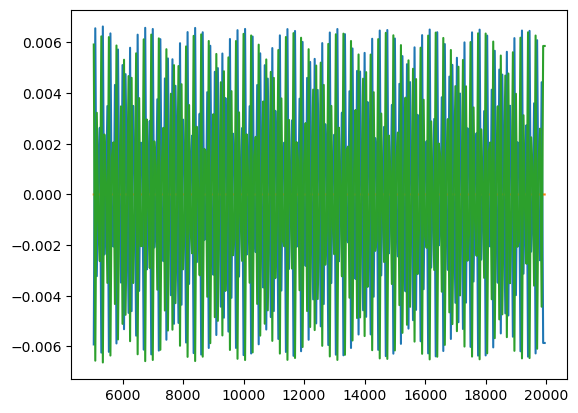

In [76]:
plt.plot(timestep[transient+1:],mlyap[transient:,0])
plt.plot(timestep[transient+1:], mlyap[transient:, 1])
plt.plot(timestep[transient+1:], mlyap[transient:, 2])

In [77]:
tspan=[0.,3000.]
t_eval=np.linspace(*tspan,10000)

In [78]:
solution= solve_ivp(msolve_combined,tspan,mics,t_eval=t_eval,args=(p,),rtol=1e-10,atol=1e-10)

In [79]:
solution

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.000e-01 ...  3.000e+03  3.000e+03]
        y: [[ 1.000e+00  1.260e+00 ...  1.528e+00  1.460e+00]
            [ 1.000e+00  7.285e-01 ... -7.696e-02 -3.762e-01]
            ...
            [ 5.050e-01  5.050e-01 ...  5.050e-01  5.050e-01]
            [-7.818e-02 -7.818e-02 ... -7.818e-02 -7.818e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 482138
     njev: 0
      nlu: 0

In [80]:
t= solution.t
traj= solution.y[:3,:]
d_traj= solution.y[3:,:]

In [81]:
lyapunov_exp= np.zeros((3,len(t)))

In [82]:
for i in range(1,len(t)):
    W= d_traj[:,i].reshape(3,3)
    Q,R= np.linalg.qr(W)
    # Q = Q * np.diag(np.sign(np.diag(R))) 
    # R = np.diag(np.sign(np.diag(R))) * R
    d_traj[:,i]= Q.flatten()
    lyapunov_exp[:,i]= np.log(np.abs(np.diag(R)))/t[i]

In [83]:
total_lyap= np.sum(lyapunov_exp,axis=0)

In [84]:
total_lyap

array([ 0.00000000e+00,  2.17093787e-10, -2.22039276e-10, ...,
        1.53928910e-12,  1.53643114e-12,  1.52879358e-12])

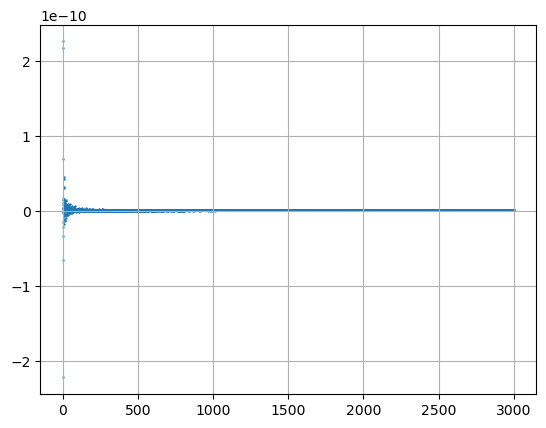

In [85]:
plt.scatter(t[1:],total_lyap[1:],s=0.5)
plt.grid(True)

### Constrained Vectors approach

In [86]:
def solveconst(x,p):
    return p**2+x**2-1

In [87]:
root= sp.optimize.fsolve(solveconst,[0.05],args=(0.5))

In [88]:
comega=1.0

In [89]:
cy0_= [0.5,0.,comega]

In [90]:
root = sp.optimize.fsolve(solveconst, [0.5], args=(cy0_[0]))

In [91]:
cy0=np.array([cy0_[0],root[0],comega])

In [92]:
cy0

array([0.5      , 0.8660254, 1.       ])

In [93]:

# @snoop
def const_ode(t,u,p):
    x,y,w=u
    c,rho=p

    return np.array([-w*y,w*x,-c*w-y+rho*np.sin(t)])

In [94]:
csol = solve_ivp(
    fun=const_ode,
    t_span=[0.0, 50000.0],
    y0=cy0,
    method="LSODA",
    t_eval=np.arange(0.0, 50000.0, 2 * np.pi),
    args=(p,),
    rtol=1e-9,
    atol=1e-9,
)

In [95]:
csol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.283e+00 ...  4.999e+04  5.000e+04]
        y: [[ 5.000e-01  9.100e-01 ...  3.568e-01  3.835e-02]
            [ 8.660e-01 -4.147e-01 ...  9.341e-01  9.992e-01]
            [ 1.000e+00  1.349e+00 ... -8.448e-01  2.772e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1591131
     njev: 0
      nlu: 0

In [96]:
crsol=csol.y
ctime= csol.t

In [97]:
crsol

array([[ 0.5       ,  0.90997727,  0.08551688, ...,  0.98171461,
         0.35679699,  0.03834755],
       [ 0.8660254 , -0.41465811, -0.9963367 , ..., -0.18997745,
         0.93410433,  0.99919189],
       [ 1.        ,  1.34905691,  0.41356231, ..., -1.4012715 ,
        -0.84482341,  0.27717817]])

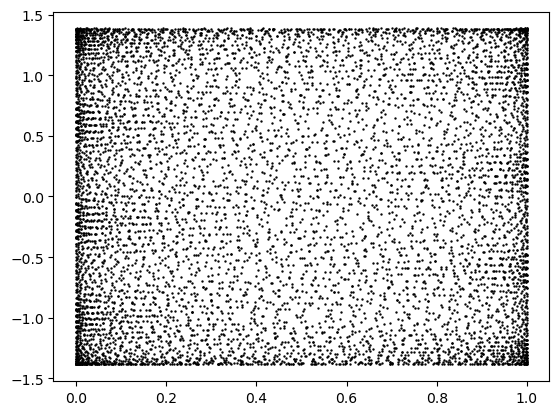

In [98]:
plt.scatter(crsol[0], rsol[1], s=0.5, c="black")

### Constrained Deviation Vector Approach without Rescaling 

In [99]:
EPS=1e-7
dcy0_= cy0_+np.random.uniform(0.,1.,3)*EPS
dcy0_[1]=0.

In [100]:
droot = sp.optimize.fsolve(solveconst, [0.5], args=(dcy0_[0]))

In [101]:
dcy0 = np.array([dcy0_[0], droot[0],dcy0_[2]])

In [102]:
dy0=dcy0-cy0

In [195]:
dy0

array([ 2.73875933e-09, -1.58122337e-09,  4.17304802e-08])

In [104]:
csoly0 = solve_ivp(
    fun=const_ode,
    t_span=[0.0, 50000.0],
    y0=cy0,
    method="LSODA",
    t_eval=np.arange(0.0, 50000.0, 1e-2),
    args=(p,),
    rtol=1e-10,
    atol=1e-10,
)

In [105]:
csoly1 = solve_ivp(
    fun=const_ode,
    t_span=[0.0, 50000.0],
    y0=dcy0,
    method="LSODA",
    t_eval=np.arange(0.0, 50000.0, 1e-2),
    args=(p,),
    rtol=1e-10,
    atol=1e-10,
)

In [106]:
inorm = np.linalg.norm(dcy0 - cy0)

In [107]:
inorm

4.1850137948325476e-08

In [108]:
crsoly0 = csoly0.y.T
crsoly1 = csoly1.y.T

In [109]:
(crsoly1 - crsoly0)[:,[0,2]]

array([[2.73875939e-09, 4.17304802e-08],
       [2.39084558e-09, 4.17451245e-08],
       [2.03839468e-09, 4.17574804e-08],
       ...,
       [1.04779429e-04, 7.46510113e-05],
       [1.13250366e-04, 8.07846440e-05],
       [1.21654487e-04, 8.68944534e-05]])

In [110]:
cret = np.linalg.norm((crsoly1 - crsoly0)[:, [0, 2]], axis=1) / inorm

In [111]:
cret

array([9.99285968e-01, 9.99125338e-01, 9.98974078e-01, ...,
       3.07412707e+03, 3.32402158e+03, 3.57228699e+03])

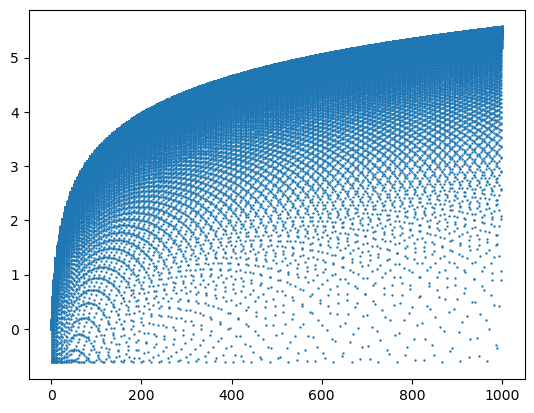

In [112]:
plt.scatter(np.arange(0.0, 50000.0, 1e-2)[:100000], np.log(cret)[:100000], s=0.5)

In [113]:
intcept1, clyap1 = (
    np.polynomial.polynomial.Polynomial.fit(
        np.arange(0.0, 50000.0, 1e-2)[:17000], np.log(cret)[:17000], 1
    )
    .convert()
    .coef
)

In [114]:
clyap1

0.014846045367218667

### Constrained Deviation Vector Approach with Rescaling

In [413]:
cy0_=np.array([0.7,0.,1.0])

In [414]:
root_=sp.optimize.fsolve(solveconst, [0.5], args=(cy0_[0]),xtol=1e-10)

In [415]:
cy0=np.array([cy0_[0],root_[0],cy0_[2]])

In [416]:
cy0

array([0.7       , 0.71414284, 1.        ])

In [417]:
EPS = 1e-5
np.random.seed(1)
cy1_ = cy0 + np.random.uniform(0.0, 1.0, len(cy0)) * EPS
cy1_[1]=0.

In [418]:
croot_ = sp.optimize.fsolve(solveconst, [0.5], args=(cy1_[0]),xtol=1e-10)

In [419]:
dcy0= np.array([cy1_[0],croot_[0],cy1_[2]])

In [420]:
dcy0

array([0.70000417, 0.71413876, 1.        ])

In [421]:
xi=dcy0-cy0

In [422]:
tf=50000.
tau=100.

In [423]:
cinorm= np.linalg.norm((dcy0-cy0)[[0,2]])

In [424]:
cinorm

4.170220203907123e-06

In [425]:
def func_build(p):

    def solveconst(x):
        return [p**2+x**2-1]
    
    return solveconst

In [426]:
f = func_build(cy1_[0])
mproot_=mpmath.findroot(f, cy1_[0], solver="mdnewton", tol=1e-28).tolist()[0]
mproot= np.array(mproot_,dtype=float)

In [427]:
mproot

array([0.71413876])

In [451]:
# @snoop
def cevolvelyap2(y0,y1,p0):
    ti=0.0
    timestep = np.arange(ti, tf + tau, tau)

    re = np.zeros((len(timestep)))

    for i in range(len(timestep)-1):
        t_span=[0.,tau]

        csoly0 = solve_ivp(
            fun=const_ode,
            t_span=t_span,
            y0=y0,
            method="LSODA",
            t_eval=[tau],
            args=(p,),
            rtol=1e-10,
            atol=1e-10,
            max_step=tau
        ).y[:,-1]

        csoly1 = solve_ivp(
            fun=const_ode,
            t_span=t_span,
            y0=y1,
            method="LSODA",
            t_eval=[tau],
            args=(p,),
            rtol=1e-10,
            atol=1e-10,
            max_step=tau,
        ).y[:,-1]

        # print(solveconst(p=csoly1[0],x=csoly1[1]))

        #! Extract delybar from dely and rescale according to restricted norm
        mask=np.array([True,False,True])
        re[i + 1] = np.log(np.linalg.norm((csoly1 - csoly0)[mask]) / cinorm)

        delyr = ((csoly1 - csoly0)) / np.linalg.norm(((csoly1 - csoly0)[mask]))
        # print(np.linalg.norm(((csoly1 - csoly0)[mask])))
        delyr[~mask]=0.0

        # dum_=np.linalg.norm(((csoly1 - csoly0)[mask])),cinorm
        delyr= delyr*cinorm

        # #! Insert 0 at 1st place in delyr
        # delyr=np.insert(delyr,1,0.)

        newsoly1_= csoly0+ delyr

        croot_ = sp.optimize.fsolve(solveconst, [csoly1[1]], args=(newsoly1_[0]),xtol=1e-10)
        # f= func_build(newsoly1_[0])
        # mproot_=mpmath.findroot(f, newsoly1_[0], solver="mdnewton", tol=1e-28).tolist()[0]
        # croot_= np.array(mproot_,dtype=float)

        # if (csoly1[1] > 0 and croot_[0] < 0) or (csoly1[1] < 0 and croot_[0] > 0):
        #     croot_[0]=-croot_[0]

        y1= np.array([newsoly1_[0],croot_[0],newsoly1_[2]])
        y0= csoly0
        # dum2_ = np.linalg.norm(((y1 - y0)[mask]))

    return re

In [452]:
cretau = cevolvelyap2(cy0, dcy0, p)

In [430]:
timestep = np.arange(0.0, tf + tau, tau)

In [431]:
timestep.shape, cretau.shape

((501,), (501,))

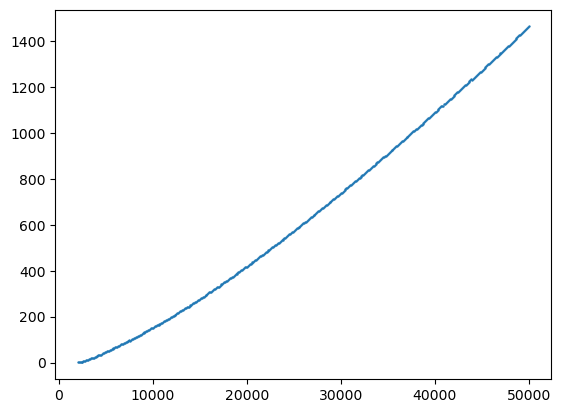

In [432]:
plt.scatter(timestep[20:], np.cumsum(cretau)[20:], s=0.5)
# plt.xlim(0.,10000.)

In [433]:
intcept, clyap2 = (
    np.polynomial.polynomial.Polynomial.fit(timestep[20:], np.cumsum(cretau)[20:], 1)
    .convert()
    .coef
)

In [434]:
clyap2

0.03128733344579589

### Constrained Jacobian Method for largest Lyapunov Exponent

In [138]:
xi0= xi/cinorm

In [139]:
xi0

array([ 9.99999962e-01, -5.77350280e-01,  2.74266514e-04])

In [140]:
cy0

array([0.5      , 0.8660254, 1.       ])

In [141]:
cics= np.array([cy0,xi0]).flatten()

In [142]:
cics

array([ 5.00000000e-01,  8.66025404e-01,  1.00000000e+00,  9.99999962e-01,
       -5.77350280e-01,  2.74266514e-04])

In [143]:
solve_combined(0.,cics,p)

array([ 0.8660254 , -0.47942554,  1.        , -0.57735028, -0.87758253,
        0.        ])

In [144]:
def cevolve_lyap(ics0, tau, tf, p):

    ti = 0.0  # * Initial Time
    timestep = np.arange(ti, tf, tau)  # * Time interval
    size = timestep.shape[0]

    X1t = np.zeros((size - 1))  # *Lyapunaov Exponents
    sum = 0.0
    ics = ics0.copy()  # *We do not want to change our initial conditions

    for i in range(0, size - 1):


        usol = solve_ivp(
            solve_combined,
            [0.0, tau],
            ics,
            t_eval=[tau],
            args=(p,),
            atol=1e-10,
            rtol=1e-10,
            max_step=tau,
        ).y[:, -1]

        xk = usol[:3]  # Orbit at t= tau
        wk = usol[3:]  # Deviations at t=tau

        # *---------------------The following algorithm is from the paper

        alphak = np.linalg.norm(wk)
        sum = sum + np.log(alphak)
        X1t[i] = sum / timestep[i + 1]
        wk0 = wk / alphak

        # *----------------------Lyapunaov Exponents calculated above
        #! Now for another time step. Set the current solution as the initial conditions for next time steps
        ics[:3] = xk
        ics[3:] = wk0

    return X1t

In [145]:
tf = 20000.
tau = 100.
cslyap = cevolve_lyap(cics, tau, tf, p)

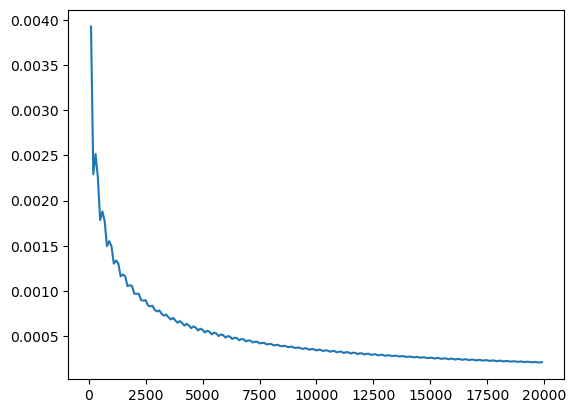

In [146]:
plt.plot(np.arange(0.0, tf, tau)[1:], cslyap)

In [147]:
np.average(cslyap[100:])

0.00026414235106844